#**Домашнеее задание: Июльский курс (2020). Pro. Занятие 19**
##**Обучение с подкреплением**
##Верхошинская Катерина Викторовна

##**LIGHT**

### **Задание:**

1. Запустите нейросеть на разном количестве тренировок, сравните результаты:
* 10 тренировок - количество выигранных очков?
* 20 тренировок - количество выигранных очков?
* 30 тренировок - количество  выигранных очков?
2. Проведите небольшую тренировочную сессию, изменив архитектуру нейросети:
* Изменив количество связей в Dense слое
* Добавив Dense слой
* Добавив Conv слой

	Результаты сравните.
3. Постарайтесь обучить нейросеть до уровня игры, равного сопернику (или хотя бы, чтобы наша сеть набирала минимум 100 очков). Результат можно достичь большим количеством тренировок. Зафиксируйте какое количество тренировок/эпох и реального времени потребовалось нейросети для обучения.


### Import библиотек

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
pip install keras==2.3

     |████████████████████████████████| 378kB 7.8MB/s 
  Found existing installation: Keras 2.3.1
    Uninstalling Keras-2.3.1:
      Successfully uninstalled Keras-2.3.1


In [ ]:
import gym         # загружаем "тренажер" Gym из платформы OpenAi, предоставляющий среду для работы над обучением с подкреплением 
import numpy as np # импортируем библиотеку для работы с массивами данных
import keras       # импортируем нейросетевую библиотеку 
from keras.models import Model, load_model # из кераса подгружаем абстрактный класс базовой модели, метод загрузки предобученной модели
from keras.layers import Dense, Flatten, Input, Lambda, Conv2D, Conv1D, MaxPooling2D, Reshape, Multiply, BatchNormalization # из кераса загружаем необходимые слои для нейросети
from keras.optimizers import RMSprop, Adam # из кераса загружаем выбранный оптимизатор
import time                                # модуль для операций со временными характеристиками
import matplotlib.pyplot as plt            # импортируем библиотеку для визуализации данных
 
# "магическая" команда python для запуска библиотеки в ноутбуке
%matplotlib inline

### Взгляд на игру



In [ ]:
env = gym.make('Pong-v0') # создаем среду игры Понг средствами OpenAI Gym('env' = environment)
observation = env.reset() # задаем начальное состояние среды, которое наблюдает агент
observation.shape         # взглянем на форму состояния среды
                          # увидим, что это изображение размером 210*160 с тремя RGB каналами

(210, 160, 3)

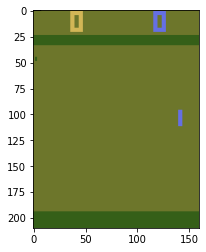

In [ ]:
plt.imshow(observation) # вызовем визуализацию состояния среды с помощью метода imshow от matplotlib.pyplot
plt.show() 

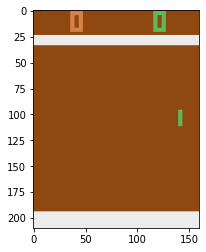

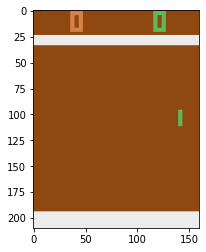

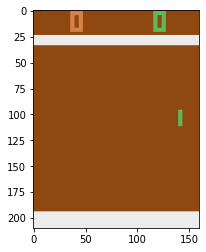

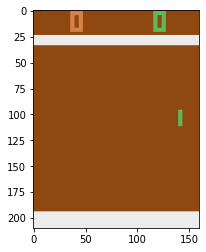

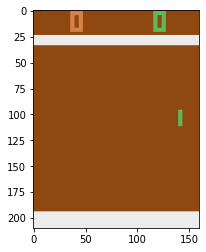

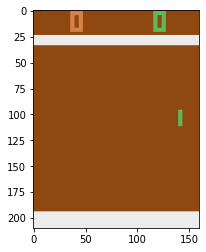

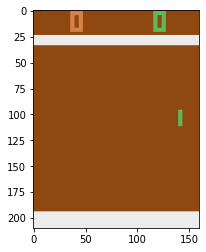

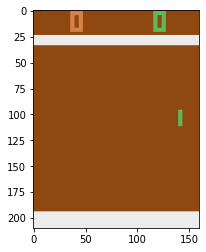

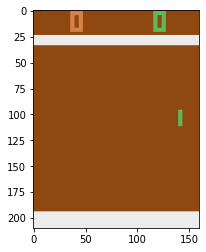

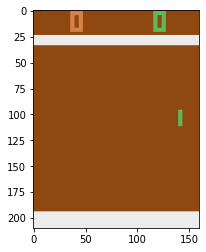

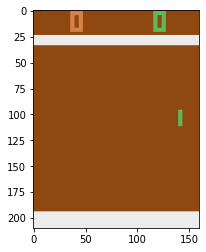

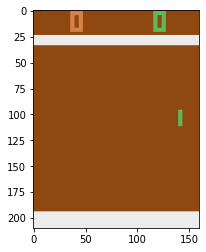

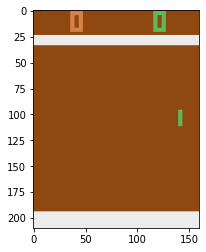

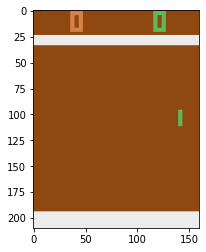

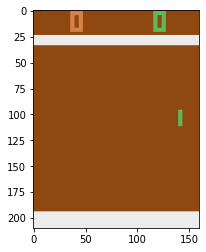

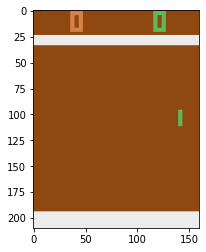

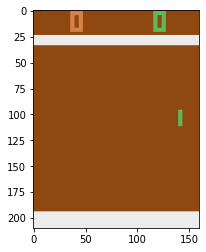

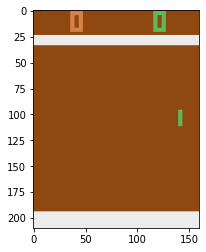

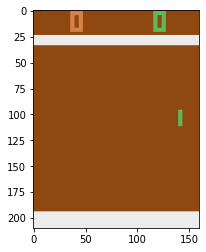

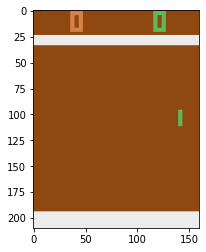

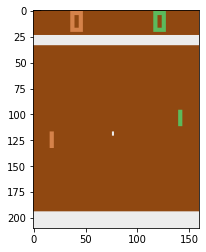

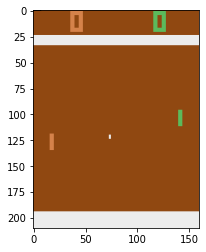

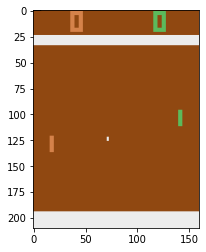

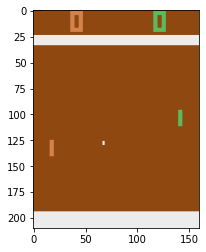

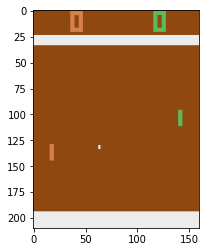

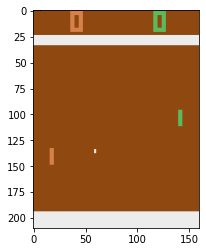

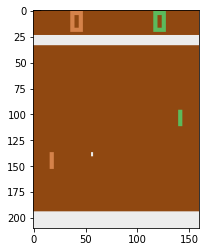

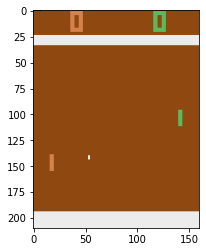

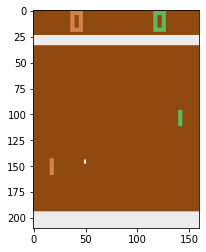

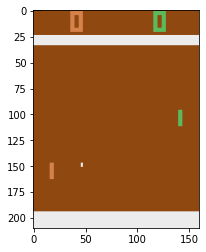

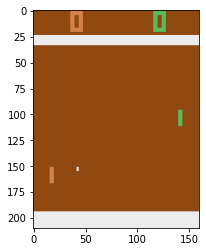

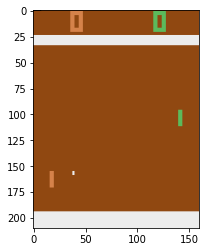

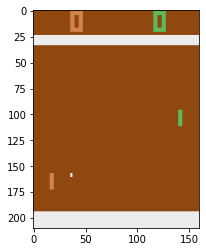

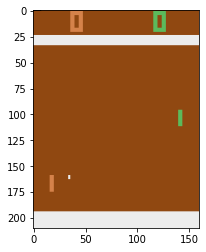

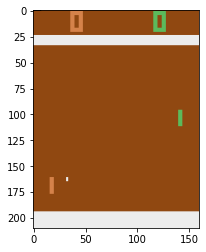

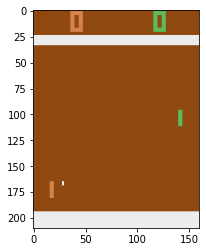

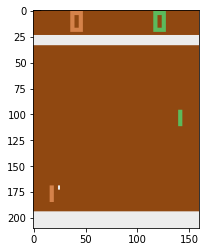

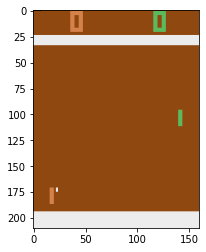

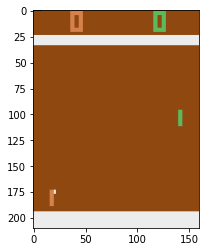

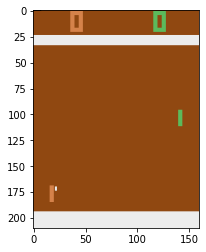

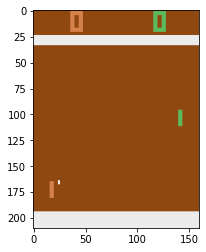

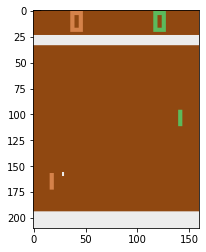

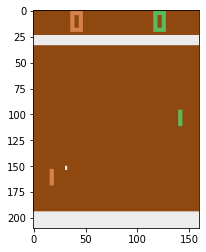

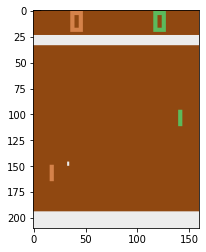

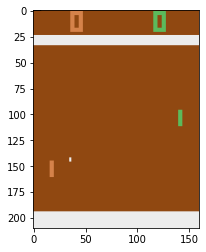

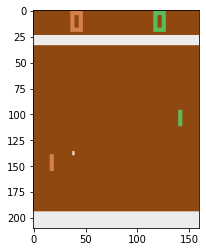

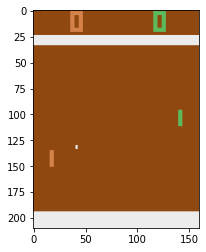

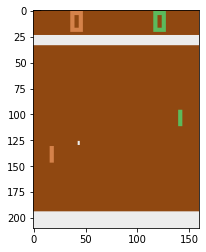

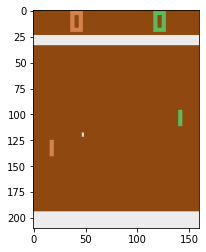

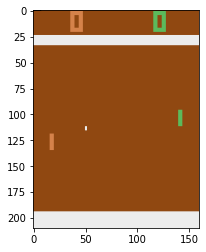

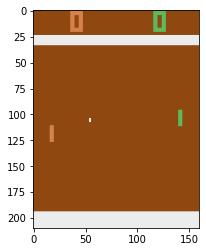

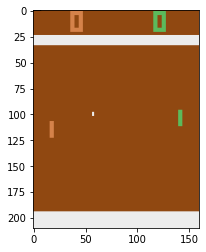

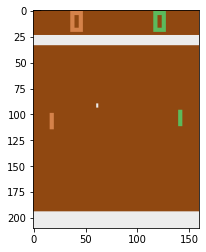

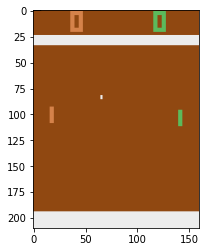

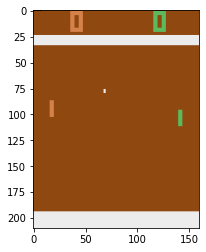

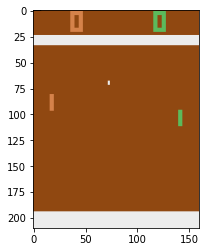

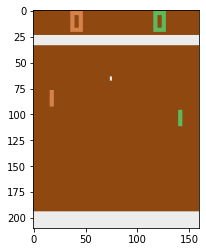

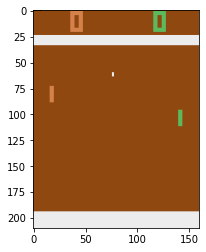

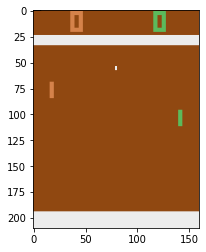

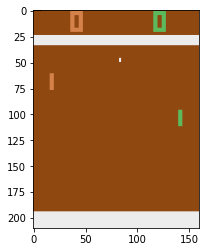

In [ ]:
# В понге:
# 0 цифровое обозначение если ракетка 'остаётся на месте'
# 2 цифровое обозначение для действия ракеткой 'сдвинуться вверх'
# 3 цифровое обозначение для действия ракеткой 'сдвинуться вниз'
 
# Проиграем вперёд игру на 30 кадров чтобы увидеть полную сцену игры
for i in range(60):
    # env.render()
    observation, reward, done, info = env.step(0) # 0 обозначает,что ничего не делаем, остаемся на месте
    plt.imshow(observation)                      # взглянем на текущее состояние среды: наш агент владеет зелёной ракеткой, появился соперник и мяч
    plt.show()
# step - такт, шаг в игре: принимает (action, действие агента), возвращает кортеж (observation, reward, done, info)
# observation (object) - текущее состояние среды, которое наблюдает агент(пиксели)
# reward (float) - награда за совершённое действие
# done (True or False) - обозначает завершился ли игровой эпизод (в понге до победы 21 очко)
# info (dict) - вспомогательная диагностическая информация, типа кол-во оставшихся жизней(неактуально для понга)

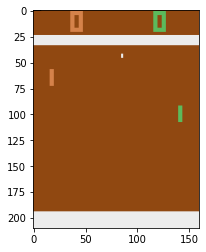

In [ ]:
# Policy(политику, стратегию агента) будет позже задавать нейросеть.
# мы подадим ей разницу между новым и предыдущим кадром, чтобы отслеживалось смещение мяча/ракеток и данные были понятными
newObservation, reward, done, info = env.step(2) # задаем очередным шагом следующий кадр, при этом смещая ракетку вверх
plt.imshow(newObservation)                       # взглянем на следующий кадр(нам смещение едва видно, либо не видно, т.к визуально длина шага мала)

### Предобработка данных


In [ ]:
# Зададим функцию предобработки данных для подачи в нейросеть
# избавимся вот всего лишнего(фон, размер и т.п), оставив на экране лишь мяч и ракетки
def preprocessFrames(newFrame,lastFrame): # подаем в функцию новый и предыдущий кадр
  nFrame = newFrame.astype(np.int32)      # переводим в целочисленный тип новый кадр
  nFrame[nFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
  nFrame[nFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
  lFrame = lastFrame.astype(np.int32)     # переводим в целочисленный тип предыдущий кадр
  lFrame[lFrame==144] = 0                 # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)
  lFrame[lFrame==72] = 0                  # удаляем цвета заднего фона в новом кадре(144 и 72 - значения каналов, дающих оранжевый цвет, зануляем)  
  deltaFrame = nFrame - lFrame            # задаём разницу между новым и предыдущим кадром   
  # Отрезаем верхнюю и нижнюю(неинформативные) части экрана, по 35 сверху и снизу
  deltaFrame = deltaFrame[35:195]         # срезали края по высоте, осталась картинка 160*160
  # Делаем сжатие кадра в 2 раза по обеим сторонам изображения и оставляем монотонный канал 
  deltaFrame=deltaFrame[::2,::2, 0]
  # Масштабирование чисел от 0 до 1
  maxValue = deltaFrame.max() if deltaFrame.max()> abs(deltaFrame.min()) else abs(deltaFrame.min())
  if maxValue != 0:
      deltaFrame=deltaFrame/maxValue
  return deltaFrame                       # функция вернет разницу между кадрами в оптимальном виде

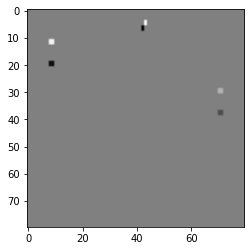

In [ ]:
plt.imshow(preprocessFrames(newObservation, observation), plt.cm.gray) # выведем результат предобработки наших кадров
# смещение здесь - это шаг от черного пикселя к светлому

In [ ]:
preprocessFrames(newObservation, observation) # выведем массив для этого состояния среды(кадра)

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
preprocessFrames(newObservation, observation).shape # выведем форму массива

(80, 80)

In [ ]:
# Cостоянием среды будет картинка 80*80, полученная вычитанием двух последовательных кадров, где по итогу все будет...
# ...заполнено нулями, а в местах смещения мяча либо ракетки - ненулевые значения.
# Далее keras'ом создадим policy, которая на основе состояния(картинки) выбирает действия.
# Output сети - вероятность того что нужно двигаться вверх

### 1) 10, 20 и 30 тренировок

#### Моделируем нейросеть



In [ ]:
# Простая модель с двумя слоями, на 200 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80))      # на входном слое сетки изображение 80*80
flattenedLayer = Flatten()(inputs) # перевели в вектор
fullConnected = Dense(200, activation='relu', use_bias=False)(flattenedLayer) # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)
policyNetworkModel.summary()       # посмотрим на модель

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


####Задаем функцию потерь в соответствии с вознаграждением


In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываем reset)
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
###########################
# Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаем...
# ...функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
###########################
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую episodeReward, награда
  def loss(yTrue,yPred):
    # подаём в кач-ве yTrue фактически сделанное действие(action) 
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас
    
    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    # вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
    # помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
    # формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # обновленная функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

In [ ]:
###########################
# Создаем керас-оптимизатор и нейронку для обучения
###########################
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

#### Генерация игрового эпизода с участием нейросети



In [ ]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

In [ ]:
###########################
# Сгенерируем эпизод игры с необученной сетью
###########################
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)


----------------------
Количество состояний в эпизоде = 1253
Форма состояния (80, 80)
Количество наград за эпизод = 1253


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# увидим что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.53215146, 0.516823, 0.5335991, 0.5118625, 0.51173145, 0.5818454, 0.5068702, 0.5210381, 0.5226564, 0.52860713, 0.5359285, 0.556522, 0.5137058, 0.5233429, 0.52069026, 0.5207669, 0.53864735, 0.51411605, 0.5260747, 0.52278453]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1]

In [ ]:
# Выведем список наград(почти везде нули, кроме тех моментов когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько мы раз выиграли в течение эпизода:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1232


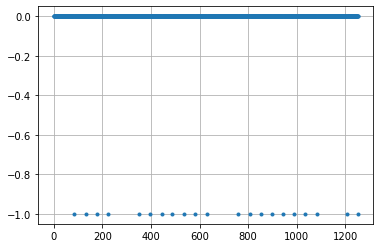

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками.
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

#### Эффективно определяем вознаграждение


In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1,-1,-1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

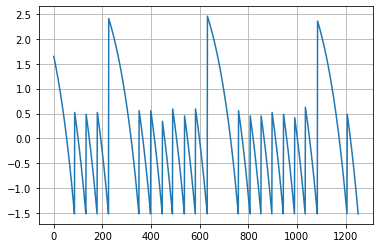

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси
ax.grid(True)  # с фоновой сеткой
# новое распределение наград даст лучшее отражение эффективности действий

#### Пример игрового эпизода с последующей тренировкой сети


In [ ]:
# Сгенерируем новый игровой эпизод:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = "+str(len(statesList))) # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = "+str(statesList[0].shape))  # выведем форму для каждого состояния
print("Список наград  = "+str(len(rewardsList)))            # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды = 1029
Форма состояний среды = (80, 80)
Список наград  = 1029


In [ ]:
# Подготовим данные для тренировки    
x = np.array(statesList)          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1029, 1)
Форма состояний среды = (1029, 80, 80)
Форма фактических движений = (1029, 1)


In [ ]:
episodeReward[:20]

array([[3.0374975],
       [3.0023756],
       [2.966899 ],
       [2.931064 ],
       [2.894867 ],
       [2.8583045],
       [2.8213725],
       [2.7840674],
       [2.7463856],
       [2.7083232],
       [2.6698763],
       [2.6310413],
       [2.5918136],
       [2.5521898],
       [2.5121658],
       [2.4717376],
       [2.430901 ],
       [2.3896518],
       [2.3479857],
       [2.3058994]], dtype=float32)

In [ ]:
# "Скормим" модели новые 'x' и 'y'
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Epoch 1/1
1029/1029 [==============================] - 0s 252us/step - loss: -0.0030


In [ ]:
###########################
# Теперь создадим серию игровых эпизодов
# Затем предобработаем данные и скормим нейросети
###########################
def generateEpisodeBatchesTraining(model, nBatches=10): # подаем на вход заданное количество игровых серий
  env = gym.make('Pong-v0')                             # создаем игровую среду Pong
  batchStateList = []                                   # зададим серию списков состояний
  batchUpDownActionList = []                            # зададим серию списков движений
  batchRewardsList = []                                 # зададим серию списков наград
  batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):                             # для каждой серии 
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
    batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
 
  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
  yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
  
  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

#### Обучаем сеть на серии игровых эпизодов


обучим на 10 тренировках

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 63сек
Ошибка на тренировке = -0.04872
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 2
Время тренировки = 67сек
Ошибка на тренировке = -0.07416
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 3
Время тренировки = 87сек
Ошибка на тренировке = -0.0535
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 4
Время тренировки = 90сек
Ошибка на тренировке = -0.05855
Выиграли очков = 13 Проиграли очков = 210

Тренировка = 5
Время тренировки = 91сек
Ошибка на тренировке = -0.0644
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 6
Время тренировки = 99сек
Ошибка на тренировке = -0.07358
Выиграли очков = 23 Проиграли очков = 210

Тренировка = 7
Время тренировки = 113сек
Ошибка на тренировке = -0.08697
Выиграли очков = 26 Проиграли очков = 210

Тренировка = 8
Время тренировки = 100сек
Ошибка на тренировке = -0.07536
Выиграли очков = 35 Проиграли очков = 210

Тренировка = 9
Время тренировки = 104сек
Ошибка на тренировке = -0.0716
Выиграли о

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel20.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel20_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple20.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 107сек
Ошибка на тренировке = -0.09095
Выиграли очков = 37 Проиграли очков = 210

Тренировка = 2
Время тренировки = 104сек
Ошибка на тренировке = -0.10355
Выиграли очков = 50 Проиграли очков = 210

Тренировка = 3
Время тренировки = 97сек
Ошибка на тренировке = -0.11066
Выиграли очков = 32 Проиграли очков = 210

Тренировка = 4
Время тренировки = 103сек
Ошибка на тренировке = -0.09106
Выиграли очков = 41 Проиграли очков = 210

Тренировка = 5
Время тренировки = 108сек
Ошибка на тренировке = -0.06936
Выиграли очков = 17 Проиграли очков = 210

Тренировка = 6
Время тренировки = 123сек
Ошибка на тренировке = -0.07135
Выиграли очков = 25 Проиграли очков = 210

Тренировка = 7
Время тренировки = 128сек
Ошибка на тренировке = -0.08058
Выиграли очков = 54 Проиграли очков = 210

Тренировка = 8
Время тренировки = 118сек
Ошибка на тренировке = -0.09971
Выиграли очков = 42 Проиграли очков = 210

Тренировка = 9
Время тренировки = 113сек
Ошибка на тренировке = -0.08798


сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel30.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel30_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple30.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 120сек
Ошибка на тренировке = -0.09303
Выиграли очков = 48 Проиграли очков = 210

Тренировка = 2
Время тренировки = 95сек
Ошибка на тренировке = -0.06282
Выиграли очков = 35 Проиграли очков = 210

Тренировка = 3
Время тренировки = 123сек
Ошибка на тренировке = -0.09194
Выиграли очков = 61 Проиграли очков = 210

Тренировка = 4
Время тренировки = 123сек
Ошибка на тренировке = -0.10081
Выиграли очков = 63 Проиграли очков = 210

Тренировка = 5
Время тренировки = 114сек
Ошибка на тренировке = -0.08732
Выиграли очков = 34 Проиграли очков = 210

Тренировка = 6
Время тренировки = 126сек
Ошибка на тренировке = -0.10625
Выиграли очков = 56 Проиграли очков = 210

Тренировка = 7
Время тренировки = 108сек
Ошибка на тренировке = -0.10195
Выиграли очков = 50 Проиграли очков = 210

Тренировка = 8
Время тренировки = 129сек
Ошибка на тренировке = -0.1065
Выиграли очков = 50 Проиграли очков = 210

Тренировка = 9
Время тренировки = 128сек
Ошибка на тренировке = -0.12506
В

#### Сыграем эпизод обученной моделью и воспроизведем видео



In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
###########################
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 10 тренировках
policyNetworkModel10 = load_model("policyNetworkModel.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel10)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 20 тренировках
policyNetworkModel20 = load_model("policyNetworkModel20.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel20)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 30 тренировках
policyNetworkModel30 = load_model("policyNetworkModel30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### Выводы:

На 10 тренировках выйграно очков: 34 


На 20 тренировках выйграно очков: 54



На 30 тренировках выйграно очков: 61

Из чего можно сделать вывод, что чем дольше тренировка тем больше выйрано очков - сеть работает все лучше и лучше.


### 2a) Изменим количество связей в Dense слое


#### Моделируем нейросеть



In [ ]:
# Простая модель с двумя слоями, на 600 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80))      # на входном слое сетки изображение 80*80
flattenedLayer = Flatten()(inputs) # перевели в вектор
fullConnected = Dense(600, activation='relu', use_bias=False)(flattenedLayer) # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)
policyNetworkModel.summary()       # посмотрим на модель

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 600)               3840000   
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 600       
Total params: 3,840,600
Trainable params: 3,840,600
Non-trainable params: 0
_________________________________________________________________


####Задаем функцию потерь в соответствии с вознаграждением


In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываем reset)
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
###########################
# Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаем...
# ...функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
###########################
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую episodeReward, награда
  def loss(yTrue,yPred):
    # подаём в кач-ве yTrue фактически сделанное действие(action) 
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас
    
    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    # вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
    # помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
    # формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # обновленная функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

In [ ]:
###########################
# Создаем керас-оптимизатор и нейронку для обучения
###########################
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

#### Генерация игрового эпизода с участием нейросети



In [ ]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

In [ ]:
###########################
# Сгенерируем эпизод игры с необученной сетью
###########################
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)

----------------------
Количество состояний в эпизоде = 1018
Форма состояния (80, 80)
Количество наград за эпизод = 1018


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# увидим что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.53431225, 0.5427736, 0.5108073, 0.5130624, 0.5465879, 0.5100425, 0.53802556, 0.5245192, 0.54730856, 0.5519001, 0.52670866, 0.53705657, 0.54045886, 0.52338195, 0.5127397, 0.5371487, 0.531574, 0.52629036, 0.52524686, 0.5193457]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1]

In [ ]:
# Выведем список наград(почти везде нули, кроме тех моментов когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько мы раз выиграли в течение эпизода:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 997


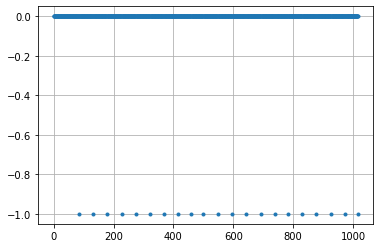

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками.
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

#### Эффективно определяем вознаграждение


In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1,-1,-1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

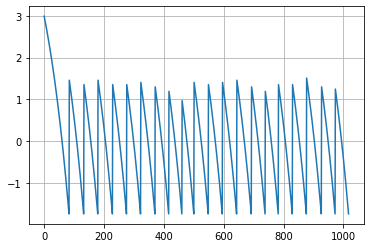

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси
ax.grid(True)  # с фоновой сеткой
# новое распределение наград даст лучшее отражение эффективности действий

#### Пример игрового эпизода с последующей тренировкой сети


In [ ]:
# Сгенерируем новый игровой эпизод:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = "+str(len(statesList))) # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = "+str(statesList[0].shape))  # выведем форму для каждого состояния
print("Список наград  = "+str(len(rewardsList)))            # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды = 1548
Форма состояний среды = (80, 80)
Список наград  = 1548


In [ ]:
# Подготовим данные для тренировки    
x = np.array(statesList)          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1548, 1)
Форма состояний среды = (1548, 80, 80)
Форма фактических движений = (1548, 1)


In [ ]:
episodeReward[:20]

array([[0.38012943],
       [0.3686315 ],
       [0.35701746],
       [0.34528604],
       [0.33343616],
       [0.3214666 ],
       [0.3093761 ],
       [0.29716355],
       [0.28482756],
       [0.27236697],
       [0.25978053],
       [0.24706696],
       [0.23422499],
       [0.22125325],
       [0.20815048],
       [0.19491544],
       [0.18154663],
       [0.16804291],
       [0.15440261],
       [0.14062464]], dtype=float32)

In [ ]:
# "Скормим" модели новые 'x' и 'y'
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Epoch 1/1
1548/1548 [==============================] - 0s 178us/step - loss: -9.5019e-04


In [ ]:
###########################
# Теперь создадим серию игровых эпизодов
# Затем предобработаем данные и скормим нейросети
###########################
def generateEpisodeBatchesTraining(model, nBatches=10): # подаем на вход заданное количество игровых серий
  env = gym.make('Pong-v0')                             # создаем игровую среду Pong
  batchStateList = []                                   # зададим серию списков состояний
  batchUpDownActionList = []                            # зададим серию списков движений
  batchRewardsList = []                                 # зададим серию списков наград
  batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):                             # для каждой серии 
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
    batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
 
  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
  yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
  
  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

#### Обучаем сеть на серии игровых эпизодов


In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 54сек
Ошибка на тренировке = -0.10141
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 2
Время тренировки = 66сек
Ошибка на тренировке = -0.0964
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 3
Время тренировки = 71сек
Ошибка на тренировке = -0.07929
Выиграли очков = 11 Проиграли очков = 210

Тренировка = 4
Время тренировки = 71сек
Ошибка на тренировке = -0.07855
Выиграли очков = 11 Проиграли очков = 210

Тренировка = 5
Время тренировки = 65сек
Ошибка на тренировке = -0.12454
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 6
Время тренировки = 81сек
Ошибка на тренировке = -0.09242
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 7
Время тренировки = 68сек
Ошибка на тренировке = -0.09448
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 8
Время тренировки = 78сек
Ошибка на тренировке = -0.07701
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 9
Время тренировки = 89сек
Ошибка на тренировке = -0.08284
Выиграли очк

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel20.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel20_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple20.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 72сек
Ошибка на тренировке = -0.12231
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 2
Время тренировки = 95сек
Ошибка на тренировке = -0.10013
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 3
Время тренировки = 89сек
Ошибка на тренировке = -0.11984
Выиграли очков = 16 Проиграли очков = 210

Тренировка = 4
Время тренировки = 98сек
Ошибка на тренировке = -0.09453
Выиграли очков = 11 Проиграли очков = 210

Тренировка = 5
Время тренировки = 76сек
Ошибка на тренировке = -0.13063
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 6
Время тренировки = 81сек
Ошибка на тренировке = -0.13075
Выиграли очков = 13 Проиграли очков = 210

Тренировка = 7
Время тренировки = 67сек
Ошибка на тренировке = -0.19955
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 8
Время тренировки = 87сек
Ошибка на тренировке = -0.11724
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 9
Время тренировки = 104сек
Ошибка на тренировке = -0.10321
Выиграли

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel30.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel30_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple30.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 103сек
Ошибка на тренировке = -0.08788
Выиграли очков = 27 Проиграли очков = 210

Тренировка = 2
Время тренировки = 105сек
Ошибка на тренировке = -0.10724
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 3
Время тренировки = 107сек
Ошибка на тренировке = -0.09723
Выиграли очков = 9 Проиграли очков = 210

Тренировка = 4
Время тренировки = 123сек
Ошибка на тренировке = -0.09396
Выиграли очков = 22 Проиграли очков = 210

Тренировка = 5
Время тренировки = 109сек
Ошибка на тренировке = -0.1057
Выиграли очков = 20 Проиграли очков = 210

Тренировка = 6
Время тренировки = 88сек
Ошибка на тренировке = -0.14733
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 7
Время тренировки = 106сек
Ошибка на тренировке = -0.09052
Выиграли очков = 38 Проиграли очков = 210

Тренировка = 8
Время тренировки = 108сек
Ошибка на тренировке = -0.07835
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 9
Время тренировки = 114сек
Ошибка на тренировке = -0.08428
Выи

#### Сыграем эпизод обученной моделью и воспроизведем видео



In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
###########################
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 10 тренировках
policyNetworkModel = load_model("policyNetworkModel.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 20 тренировках
policyNetworkModel20 = load_model("policyNetworkModel20.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel20)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 30 тренировках
policyNetworkModel30 = load_model("policyNetworkModel30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 2b) Добавим Dense слой

#### Моделируем нейросеть



In [ ]:
# Простая модель с двумя слоями, на 200 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80))      # на входном слое сетки изображение 80*80
flattenedLayer = Flatten()(inputs) # перевели в вектор
fullConnected = Dense(200, activation='relu', use_bias=False)(flattenedLayer)
fullConnected = Dense(200, activation='relu', use_bias=False)(flattenedLayer) # задали 200 нейронов и активацию релу
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(fullConnected)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)
policyNetworkModel.summary()       # посмотрим на модель

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 80, 80)            0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 200)               1280000   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 200       
Total params: 1,280,200
Trainable params: 1,280,200
Non-trainable params: 0
_________________________________________________________________


####Задаем функцию потерь в соответствии с вознаграждением


In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываем reset)
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
###########################
# Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаем...
# ...функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
###########################
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую episodeReward, награда
  def loss(yTrue,yPred):
    # подаём в кач-ве yTrue фактически сделанное действие(action) 
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас
    
    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    # вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
    # помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
    # формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # обновленная функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

In [ ]:
###########################
# Создаем керас-оптимизатор и нейронку для обучения
###########################
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

#### Генерация игрового эпизода с участием нейросети



In [ ]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

In [ ]:
###########################
# Сгенерируем эпизод игры с необученной сетью
###########################
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)

----------------------
Количество состояний в эпизоде = 1169
Форма состояния (80, 80)
Количество наград за эпизод = 1169


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# увидим что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.48923448, 0.4914186, 0.5045523, 0.4979896, 0.48891738, 0.49615577, 0.4990871, 0.47994143, 0.5073843, 0.5022315, 0.49181557, 0.48010072, 0.48630694, 0.49738553, 0.50851303, 0.509203, 0.5019027, 0.5053776, 0.48626804, 0.49956492]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0]

In [ ]:
# Выведем список наград(почти везде нули, кроме тех моментов когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько мы раз выиграли в течение эпизода:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1148


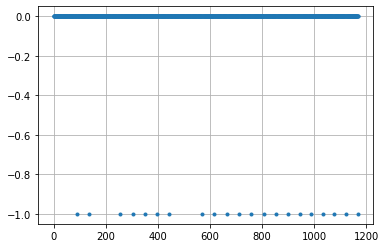

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками.
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

#### Эффективно определяем вознаграждение


In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1,-1,-1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

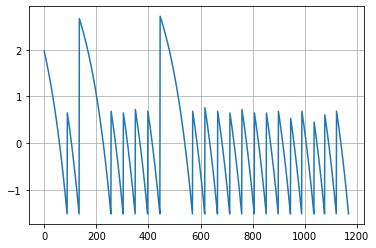

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси
ax.grid(True)  # с фоновой сеткой
# новое распределение наград даст лучшее отражение эффективности действий

#### Пример игрового эпизода с последующей тренировкой сети


In [ ]:
# Сгенерируем новый игровой эпизод:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = "+str(len(statesList))) # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = "+str(statesList[0].shape))  # выведем форму для каждого состояния
print("Список наград  = "+str(len(rewardsList)))            # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды = 1339
Форма состояний среды = (80, 80)
Список наград  = 1339


In [ ]:
# Подготовим данные для тренировки    
x = np.array(statesList)          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1339, 1)
Форма состояний среды = (1339, 80, 80)
Форма фактических движений = (1339, 1)


In [ ]:
episodeReward[:20]

array([[0.18678184],
       [0.17826581],
       [0.16966374],
       [0.16097479],
       [0.1521981 ],
       [0.14333273],
       [0.13437787],
       [0.12533249],
       [0.11619575],
       [0.10696673],
       [0.09764449],
       [0.0882281 ],
       [0.07871655],
       [0.06910893],
       [0.05940434],
       [0.04960163],
       [0.03970002],
       [0.02969825],
       [0.01959554],
       [0.00939075]], dtype=float32)

In [ ]:
# "Скормим" модели новые 'x' и 'y'
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Epoch 1/1
1339/1339 [==============================] - 0s 161us/step - loss: 2.7264e-04


In [ ]:
###########################
# Теперь создадим серию игровых эпизодов
# Затем предобработаем данные и скормим нейросети
###########################
def generateEpisodeBatchesTraining(model, nBatches=10): # подаем на вход заданное количество игровых серий
  env = gym.make('Pong-v0')                             # создаем игровую среду Pong
  batchStateList = []                                   # зададим серию списков состояний
  batchUpDownActionList = []                            # зададим серию списков движений
  batchRewardsList = []                                 # зададим серию списков наград
  batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):                             # для каждой серии 
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
    batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
 
  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
  yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
  
  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

#### Обучаем сеть на серии игровых эпизодов


In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 57сек
Ошибка на тренировке = -0.03008
Выиграли очков = 6 Проиграли очков = 210

Тренировка = 2
Время тренировки = 60сек
Ошибка на тренировке = -0.04383
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 3
Время тренировки = 62сек
Ошибка на тренировке = -0.04602
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 4
Время тренировки = 60сек
Ошибка на тренировке = -0.07215
Выиграли очков = 3 Проиграли очков = 210

Тренировка = 5
Время тренировки = 73сек
Ошибка на тренировке = -0.03791
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 6
Время тренировки = 77сек
Ошибка на тренировке = -0.03772
Выиграли очков = 21 Проиграли очков = 210

Тренировка = 7
Время тренировки = 75сек
Ошибка на тренировке = -0.04976
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 8
Время тренировки = 61сек
Ошибка на тренировке = -0.08052
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 9
Время тренировки = 78сек
Ошибка на тренировке = -0.04855
Выиграли очк

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel20.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel20_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple20.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 87сек
Ошибка на тренировке = -0.07911
Выиграли очков = 13 Проиграли очков = 210

Тренировка = 2
Время тренировки = 87сек
Ошибка на тренировке = -0.05223
Выиграли очков = 16 Проиграли очков = 210

Тренировка = 3
Время тренировки = 80сек
Ошибка на тренировке = -0.07154
Выиграли очков = 18 Проиграли очков = 210

Тренировка = 4
Время тренировки = 89сек
Ошибка на тренировке = -0.07992
Выиграли очков = 20 Проиграли очков = 210

Тренировка = 5
Время тренировки = 73сек
Ошибка на тренировке = -0.10875
Выиграли очков = 13 Проиграли очков = 210

Тренировка = 6
Время тренировки = 99сек
Ошибка на тренировке = -0.0822
Выиграли очков = 32 Проиграли очков = 210

Тренировка = 7
Время тренировки = 93сек
Ошибка на тренировке = -0.07898
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 8
Время тренировки = 85сек
Ошибка на тренировке = -0.07744
Выиграли очков = 16 Проиграли очков = 210

Тренировка = 9
Время тренировки = 92сек
Ошибка на тренировке = -0.09149
Выиграли 

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel30.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel30_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple30.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 100сек
Ошибка на тренировке = -0.07406
Выиграли очков = 24 Проиграли очков = 210

Тренировка = 2
Время тренировки = 93сек
Ошибка на тренировке = -0.08913
Выиграли очков = 14 Проиграли очков = 210

Тренировка = 4
Время тренировки = 107сек
Ошибка на тренировке = -0.05726
Выиграли очков = 18 Проиграли очков = 210

Тренировка = 5
Время тренировки = 116сек
Ошибка на тренировке = -0.06698
Выиграли очков = 32 Проиграли очков = 210

Тренировка = 6
Время тренировки = 107сек
Ошибка на тренировке = -0.08772
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 7
Время тренировки = 105сек
Ошибка на тренировке = -0.06592
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 8
Время тренировки = 102сек
Ошибка на тренировке = -0.07377
Выиграли очков = 19 Проиграли очков = 210

Тренировка = 9
Время тренировки = 115сек
Ошибка на тренировке = -0.09687
Выиграли очков = 27 Проиграли очков = 210

Тренировка = 10
Время тренировки = 104сек
Ошибка на тренировке = -0.08399


#### Сыграем эпизод обученной моделью и воспроизведем видео



In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
###########################
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 10 тренировках
policyNetworkModel = load_model("policyNetworkModel.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 20 тренировках
policyNetworkModel20 = load_model("policyNetworkModel20.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel20)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 30 тренировках
policyNetworkModel30 = load_model("policyNetworkModel30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


### 2c) Добавим Conv слой

#### Моделируем нейросеть



In [ ]:
# Простая модель с двумя слоями, на 200 нейронов в скрытом слое и сигмоидой на выходе
inputs = Input(shape=(80,80))      # на входном слое сетки изображение 80*80
x = Conv1D(8, 1, strides = 1, activation='relu', padding = 'same')(inputs)
x = Flatten()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu', kernel_initializer = init2)(x)
sigmoidOutput = Dense(1, activation='sigmoid', use_bias=False)(x)       # сигмоида на выходе
policyNetworkModel = Model(inputs=inputs, outputs=sigmoidOutput)                    # собрали модель стратегии(Model - абстрактный класс базовой модели)
policyNetworkModel.summary()       # посмотрим на модель

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_37 (InputLayer)        (None, 80, 80)            0         
_________________________________________________________________
conv1d_22 (Conv1D)           (None, 80, 8)             648       
_________________________________________________________________
flatten_24 (Flatten)         (None, 640)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 640)               2560      
_________________________________________________________________
dense_11 (Dense)             (None, 512)               328192    
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 512       
Total params: 331,912
Trainable params: 330,632
Non-trainable params: 1,280
_________________________________________________

####Задаем функцию потерь в соответствии с вознаграждением


In [ ]:
# episode - одна тренировочная игра от начала партии до перезагрузки (розыгрыш эпизода до 21 очка; после победы или поражения вызываем reset)
episodeReward = Input(shape=(1,), name='episodeReward') # задаем награду за эпизод

In [ ]:
###########################
# Функция потерь в керасе имеет вид def loss(yTrue,yPred):...А так как нам нужно включить reward в loss, создаем...
# ...функцию rewardedLoss поверх неё, чтобы на входе добавить episodeReward
###########################
def rewardedLoss(episodeReward): # задаем новую функцию потерь, принимающую episodeReward, награда
  def loss(yTrue,yPred):
    # подаём в кач-ве yTrue фактически сделанное действие(action) 
    # если фактически сделанное действие было движением вверх - подаем 1 на yTrue, если нет то подаем 0
    # yPred - выход сетки(вероятность выбора движения вверх)
    # мы не подаём yPred в нейронку, его вычисляет керас
    
    # сначала log(0) and log(1) неопределены - загоняем yPred между значениями:
    tmpPred = Lambda(lambda x: keras.backend.clip(x,0.05,0.95))(yPred)
    # вычисляем логарифм вероятности. yPred - вероятность выбора движения вверх 
    # помним что yTrue = 1 когда фактически выбрано движение вверх, и 0 - когда вниз
    # формула похожа на кросс-энтропию в керасе, но здесь мы прописываем её вручную, чтобы умножить на значение награды
    tmpLoss = Lambda(lambda x:-yTrue*keras.backend.log(x)-(1-yTrue)*(keras.backend.log(1-x)))(tmpPred)
    # обновленная функция потерь - "функция политики"
    policyLoss = Multiply()([tmpLoss, episodeReward]) #добавляем в loss умножение на награду за эпизод
    return policyLoss # ввели обновленную функцию политики
  return loss         # возвращаем обновленную функцию политики

In [ ]:
###########################
# Создаем керас-оптимизатор и нейронку для обучения
###########################
episodeReward = Input(shape=(1,), name='episodeReward')                             # задаем награду за эпизод
policyNetworkTrain = Model(inputs=[inputs, episodeReward],outputs=sigmoidOutput)    # задаем сеть с добавлением на вход награды
 
myOptimizer = RMSprop(lr=0.0001)                                                    # выбрали оптимизатор с заданной скоростью обучения
policyNetworkTrain.compile(optimizer=myOptimizer, loss=rewardedLoss(episodeReward)) # задаем сеть с новой функцией потерь policy

#### Генерация игрового эпизода с участием нейросети



In [ ]:
###########################
# Создадим функцию, которая будет генерировать игровой эпизод с участием нейросети
###########################
#игра начнется с того, что в новом эпизоде наш агент сделает движение("actualAction") вверх с вероятностью(upProbability), которую предсказала наша...
#...сетка policyNetwork, принявшая на вход состояние среды reshapedInput с подбитой под сеть формой. 
#reshapedInput же получили из состояния processedNetworkInput, которое представляет собой разницу в кадрах между новым и предыдущим...
#...кадром, полученную функцией preprocessFrames.
 
 
def generateEpisode(policyNetwork): # подаем на вход функции модель нейросети
  statesList = []                   # список состояний в течение эпизода, размер = (x,80,80)
  upDownActionList=[]               # список движений в течение эпизода: вверх - 1, вниз - 0
  rewardsList=[]                    # список наград за каждое действие
  networkOutputList=[]              # на выходе нейросети - вероятность что нужно идти вверх; собираем список из вероятности на каждом шаге
  env=gym.make("Pong-v0")           # cоздали среду
  observation = env.reset()         # перезагрузили состояние среды
  newObservation = observation      # получили новое состояние, которое наблюдает агент
  done = False                      # игровой эпизод активен(не завершён)
 
  while done == False: # пока игровой эпизод не завершён
    # На вход сети будет подаваться очередное состояние - разница между кадрами. 
    processedNetworkInput = preprocessFrames(newFrame=newObservation, lastFrame=observation) # зададим это состояние
    statesList.append(processedNetworkInput) # добавим в список состояний (впоследствие станет 'x'ом для входа в нейронку)
    reshapedInput = np.expand_dims(processedNetworkInput, axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
    upProbability = policyNetwork.predict(reshapedInput, batch_size=1)[0][0] # задаем вероятность шага вверх
    networkOutputList.append(upProbability) # добавляем к списку из вероятности идти вверх на каждом шаге
    actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability, 1-upProbability])
    # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
 
    if actualAction == 2:        # если пошли вверх
      upDownActionList.append(1) # добавляем единицу в список движений в течение эпизода
    else:                        # если не пошли вверх
      upDownActionList.append(0) # то добавляем ноль
 
    observation = newObservation # текущий newObservation записываем как старый перед тем, как сделать следующий шаг
    newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    rewardsList.append(reward)   # добавили текущую награду в список
 
    if done: # если игровой эпизод закончен
      break  # завершаем цикл
 
  env.close() # закрываем текущую среду
  return statesList, upDownActionList, rewardsList, networkOutputList
  # функция возвращает: список состояний в течение эпизода,список движений в течение эпизода, список наград за каждое действие,
  # и список вероятностей того, что нужно идти вверх

In [ ]:
###########################
# Сгенерируем эпизод игры с необученной сетью
###########################
statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(policyNetworkModel)
print("----------------------")
print("Количество состояний в эпизоде = "+str(len(statesList))) # количество состояний (кадров) в эпизоде
print("Форма состояния "+str(statesList[0].shape))              # форма каждого состояния
print("Количество наград за эпизод = "+str(len(rewardsList)))   # количество наград за эпизод(включая нулевые награды)

----------------------
Количество состояний в эпизоде = 1499
Форма состояния (80, 80)
Количество наград за эпизод = 1499


In [ ]:
# Взглянем на фрагмент списка из вероятности идти вверх на каждом шаге.
print(networkOutputList[50:70])
# увидим что на каждом шаге вероятность крутится около 50% - сеть пока не понимает куда лучше шагать

[0.47121263, 0.49490926, 0.49017817, 0.5092933, 0.50196874, 0.48293668, 0.49295458, 0.4961609, 0.472023, 0.48041368, 0.49854383, 0.47758687, 0.47988668, 0.47066218, 0.46428126, 0.49797726, 0.4937061, 0.49664727, 0.49145004, 0.4953119]


In [ ]:
# Взглянем на фактические действия: 1 - вверх, 0 - вниз
upDownActionList[50:70]
# Соответственно шаги также были случайными

[0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0]

In [ ]:
# Выведем список наград(почти везде нули, кроме тех моментов когда выигрываем или проигрываем очко)
print(rewardsList[50:70])

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [ ]:
# Взглянем на то, сколько мы раз выиграли в течение эпизода:
print("Количество выигранных очков = "+str(len(list(filter(lambda r: r>0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,большим 0
print("Количество проигранных очков = "+str(len(list(filter(lambda r: r<0,rewardsList))))) #берем как длину списка, отфильтрованного по наградам,меньшим 0
print("Количество нулевых наград = "+str(len(list(filter(lambda r: r==0,rewardsList))))) #с фильтром по 0

Количество выигранных очков = 0
Количество проигранных очков = 21
Количество нулевых наград = 1478


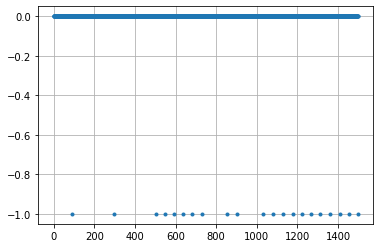

In [ ]:
# Выведем на графике полученные награды. Ненулевые награды за каждое очко будут отмечены точками.
plt.plot(rewardsList, '.') # точки будут наградами на графике
ax=plt.gca()               # получим текущие оси
ax.grid(True)              # с фоновой сеткой

#### Эффективно определяем вознаграждение


In [ ]:
# Награды пока присуждаются только тем движениям, в момент после которых было пропущено или забито очко. Но так мы научимся нескоро,
# нам нужно указать на важность действия чуть ранее, когда мы отбивали мяч ракеткой. Чтобы сетка поняла что отбивать мяч - это хорошо,
# распределим награду на все шаги, предшествующие забитому/пропущеному мячу, причем чем давнее был шаг, тем меньший коэффициент награды он получит.
 
###########################
# Сформулируем функцию, которая распределит ненулевую награду для всех шагов в удачном/неудачном розыгрыше
###########################
def processRewards(rewardList): # подадим в функцию список наград
  rewardDecay = 0.99            # установим высший коэффициент награды для ближнего действия к победному/проигрышному действию
  tmpReward = 0                 # создадим временную переменную для награды
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # создадим массив из нулей для нового формата наград
  for i in range(len(rewardList)-1,-1,-1): # будем идти в обратную сторону от награды с шагом "-1"
    if rewardList[i] == 0:                 # если награда нулевая 
      tmpReward = tmpReward*rewardDecay    # зададим ей коэффициент
      rewardDecayed[i] = tmpReward         # и добавим в массив
    else:                                  # иначе
      tmpReward = rewardList[i]            # оставим награду неизменной
      rewardDecayed[i] = tmpReward         # и введём в том же виде в массив
  # запустим нормализацию значений наград, что позволит сетке лучше понимать, где были хорошие и плохие шаги
  rewardDecayed -= np.mean(rewardDecayed)  # вычтем среднее
  rewardDecayed /= np.std(rewardDecayed)   # разделим на стандартное отклонение
  return rewardDecayed
  # функция возвращает обновленный формат наград

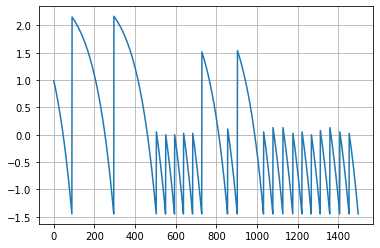

In [ ]:
# Посмотрим на распределение наград по новой функции
plt.plot(processRewards(rewardsList),'-') # добавляем в график награды с учетом новой функции
ax = plt.gca() # получим текущие оси
ax.grid(True)  # с фоновой сеткой
# новое распределение наград даст лучшее отражение эффективности действий

#### Пример игрового эпизода с последующей тренировкой сети


In [ ]:
# Сгенерируем новый игровой эпизод:
statesList,upDownActionList,rewardsList,networkOutputList = generateEpisode(policyNetworkModel)
# сыграли до 21 очка, проиграли, получили списки всех состояний среды(кадров), шагов агента, вознаграждений и предсказаний
 
print("Количество состояний среды = "+str(len(statesList))) # выведем количество состояний среды(кадров) в игровом эпизоде
print("Форма состояний среды = "+str(statesList[0].shape))  # выведем форму для каждого состояния
print("Список наград  = "+str(len(rewardsList)))            # выведем список наград в игровом эпизоде(включая нулевые)

Количество состояний среды = 1894
Форма состояний среды = (80, 80)
Список наград  = 1894


In [ ]:
# Подготовим данные для тренировки    
x = np.array(statesList)          # зададим 'x' как массив состояний 
episodeReward = np.expand_dims(processRewards(rewardsList), 1) # подобьем размер для входа в сетку
yTmp = np.array(upDownActionList) # зададим 'y' как список движений вверх(1)/вниз(0)
yTrue = np.expand_dims(yTmp, 1)   # скорректируем форму под сетку
 
 
print("Форма наград за эпизод =", episodeReward.shape) # выведем форму наград за эпизод
print("Форма состояний среды =", x.shape)              # выведем форму состояний среды ('x' для нейросети)
print("Форма фактических движений =", yTrue.shape)     # выведем форму фактических движений ('y' для нейросети)

Форма наград за эпизод = (1894, 1)
Форма состояний среды = (1894, 80, 80)
Форма фактических движений = (1894, 1)


In [ ]:
episodeReward[:20]

array([[1.2710017],
       [1.2686557],
       [1.2662859],
       [1.263892 ],
       [1.2614741],
       [1.2590319],
       [1.2565649],
       [1.2540729],
       [1.2515559],
       [1.2490133],
       [1.2464452],
       [1.2438511],
       [1.2412307],
       [1.2385839],
       [1.2359104],
       [1.2332098],
       [1.230482 ],
       [1.2277266],
       [1.2249434],
       [1.2221321]], dtype=float32)

In [ ]:
# "Скормим" модели новые 'x' и 'y'
policyNetworkTrain.fit(x=[x, episodeReward], y=yTrue)

Epoch 1/1
1894/1894 [==============================] - 1s 273us/step - loss: 0.0111


In [ ]:
###########################
# Теперь создадим серию игровых эпизодов
# Затем предобработаем данные и скормим нейросети
###########################
def generateEpisodeBatchesTraining(model, nBatches=10): # подаем на вход заданное количество игровых серий
  env = gym.make('Pong-v0')                             # создаем игровую среду Pong
  batchStateList = []                                   # зададим серию списков состояний
  batchUpDownActionList = []                            # зададим серию списков движений
  batchRewardsList = []                                 # зададим серию списков наград
  batchNetworkOutputList = []                           # зададим серию списков из вероятности идти вверх
  for i in range(nBatches):                             # для каждой серии 
    statesList, upDownActionList, rewardsList, networkOutputList = generateEpisode(model) # сгенерируем игровой эпизод
    batchStateList.extend(statesList)                   # добавим список состояний в серию списков состояний
    batchNetworkOutputList.extend(networkOutputList)    # добавим список вероятностей в серию списков из вероятности идти вверх
    batchUpDownActionList.extend(upDownActionList)      # добавим список движений в серию списков движений
    batchRewardsList.extend(rewardsList)                # добавим список наград в серию списков наград
 
  episodeReward = np.expand_dims(processRewards(batchRewardsList), 1) # зададим награды и изменим форму массива с добавлением оси
  x = np.array(batchStateList)                          # сформируем массив из серии списков состояний в качестве 'x' для нейросети
  yTmp = np.array(batchUpDownActionList)                # зададим 'y' как серию из списков движений вверх(1)/вниз(0)
  yTrue = np.expand_dims(yTmp, 1)                       # подгоним форму 'y' массива с добавлением оси
  
  history = policyNetworkTrain.fit(x=[x,episodeReward], y=yTrue, epochs=5, verbose=0) # скормим нейросети серию 'x'ов и 'y'ов
  
  batchLoss = history.history['loss'][-1]
  return batchStateList, batchUpDownActionList, batchRewardsList, batchNetworkOutputList, batchLoss
  # функция вернёт серию списков состояний, серию списков движений, серию списков наград, серию списков из вероятности идти вверх

#### Обучаем сеть на серии игровых эпизодов


In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 59сек
Ошибка на тренировке = -0.1381
Выиграли очков = 7 Проиграли очков = 210

Тренировка = 2
Время тренировки = 56сек
Ошибка на тренировке = -0.42958
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 3
Время тренировки = 58сек
Ошибка на тренировке = -0.19054
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 4
Время тренировки = 51сек
Ошибка на тренировке = -0.61241
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 5
Время тренировки = 57сек
Ошибка на тренировке = -0.41469
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 6
Время тренировки = 50сек
Ошибка на тренировке = -0.52694
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 7
Время тренировки = 49сек
Ошибка на тренировке = -0.8114
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 8
Время тренировки = 53сек
Ошибка на тренировке = -0.57614
Выиграли очков = 2 Проиграли очков = 210

Тренировка = 9
Время тренировки = 54сек
Ошибка на тренировке = -0.60368
Выиграли очков = 

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel20.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel20_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple20.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 50сек
Ошибка на тренировке = -0.8384
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 2
Время тренировки = 56сек
Ошибка на тренировке = -0.81836
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 3
Время тренировки = 50сек
Ошибка на тренировке = -0.93848
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 4
Время тренировки = 53сек
Ошибка на тренировке = -0.81579
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 5
Время тренировки = 52сек
Ошибка на тренировке = -0.77821
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 6
Время тренировки = 52сек
Ошибка на тренировке = -0.87154
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 7
Время тренировки = 53сек
Ошибка на тренировке = -0.74643
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 8
Время тренировки = 50сек
Ошибка на тренировке = -0.94759
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 9
Время тренировки = 49сек
Ошибка на тренировке = -0.97636
Выиграли очков = 

сделаем еще 10 тренировок

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel30.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel30_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple30.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 49сек
Ошибка на тренировке = -0.93456
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 2
Время тренировки = 51сек
Ошибка на тренировке = -0.88544
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 3
Время тренировки = 50сек
Ошибка на тренировке = -0.92802
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 4
Время тренировки = 53сек
Ошибка на тренировке = -0.77403
Выиграли очков = 1 Проиграли очков = 210

Тренировка = 5
Время тренировки = 49сек
Ошибка на тренировке = -0.94518
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 6
Время тренировки = 51сек
Ошибка на тренировке = -0.87402
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 7
Время тренировки = 49сек
Ошибка на тренировке = -0.93057
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 8
Время тренировки = 52сек
Ошибка на тренировке = -0.88612
Выиграли очков = 0 Проиграли очков = 210

Тренировка = 9
Время тренировки = 53сек
Ошибка на тренировке = -0.94147
Выиграли очков =

#### Сыграем эпизод обученной моделью и воспроизведем видео



In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 # создает вирт.дисплей в памяти(нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой
 
from gym.wrappers import Monitor # класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob   # модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 # библиотека поможет нам закодировать видео в 64-разрядный код, и без повреждений/изменений открыть его в ноутбуке через HTML
 
from IPython.display import HTML              # загружаем модуль чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay # активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display          # модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900))# запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env):                           # зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env                                # теперь вызов среды через функцию wrapEnv будет запускать видеозапись
 
def showVideo():                            # функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4')        # возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0:                      # если по этому пути нашелся хотя бы один файл
    mp4 = mp4list[0]                        # то берём самый свежий файл
    video = open(mp4, 'r+b').read()         # открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video)       # кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео(типа кнопки паузы и т.п) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива описывающая объект в случае невозможности отображения - "alt="test""
    
  else:                           # если путь не нашелся 
    print("Could not find video") # то выведем на печать, что не смог найти видео

In [ ]:
###########################
# Задаем функцию сыграть и показать игру
###########################
def playAndShowEpisode(policyNetwork): # подаем на вход функции модель нейросети
    env = wrapEnv(gym.make('Pong-v0')) # создаем среду в режиме записи
    done = False                       # игровой эпизод не завершён
    observation = env.reset()          # задаем начальное состояние среды, которое наблюдает агент
    newObservation = observation       # задали новое состояние которое наблюдает агент
    while done == False:               # пока игровой эпизод не завершён
        # На вход сети будет подаваться очередное состояние - разница между кадрами. 
        processedNetworkInput = preprocessFrames(newFrame=newObservation,lastFrame=observation) # зададим это состояние
        reshapedInput = np.expand_dims(processedNetworkInput,axis=0) # размер 'x' - (80,80), делаем размерность (x,(1,80,80))
 
        upProbability = policyNetwork.predict(reshapedInput,batch_size=1)[0][0] # задаем вероятность шага вверх
        actualAction = np.random.choice(a=[2,3], size=1, p=[upProbability,1-upProbability])
        # сделаем фактический шаг либо вверх(2) c вероятностью upProbability, либо вниз(3) с обратной вероятностью
        
        env.render()                   # запускаем воспроизведение среды
        
        observation = newObservation   # текущий newObservation записываем как старый, перед тем как сделать следующий шаг
        newObservation, reward, done, info = env.step(actualAction) # сделали новый шаг, получили новую награду, новое состояние
 
    env.close() # закрываем игровую среду после окончания игры
    showVideo() # показать видео игры

In [ ]:
# Взглянем как сыграет сетка, обученная на 10 тренировках
policyNetworkModel = load_model("policyNetworkModel.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 20 тренировках
policyNetworkModel20 = load_model("policyNetworkModel20.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel20)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
# Взглянем как сыграет сетка, обученная на 30 тренировках
policyNetworkModel30 = load_model("policyNetworkModel30.h5") # подгружаем модель из сохранённых
playAndShowEpisode(policyNetworkModel30)                     # запускаем игровой эпизод

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


#### Выводы: 


Проведя небольшую тренировочную сессию, изменяя архитектуру нейросети, а именно
* Изменив количество связей в Dense слое
* Добавив Dense слой
* Добавив Conv слой

можно сделать вывод что добавление Conv слоя не принесло ничего хорошего,
сеть с трулом выйгрывала 1 очко! Как бы я не старалась изменить архитектуру с Conv слоями - результат всегда был печальный.

Изменение количества связей в Dense слое, и добавление Dense слоёв вносят примерно равноценные изменения. В том и том случае после 30 тренировок было выйграно в 2 раза меньше очков чем в изначальной архитектуре.
Трудно говорить о данном подходе в долгосрочной перспективе и делать окончательные выводы, ведь на той же 200 или 300 этохе результат возможно и превзошел бы оригинальную архитектуру. Но в связи с очень долгим обучением сети данный эксперемент невозможен, да и по условию задачи тренироваочная сессия должна быть небольшой.

### 3. Постарайтесь обучить нейросеть до уровня игры, равного сопернику (или хотя бы, чтобы наша сеть набирала минимум 100 очков). Результат можно достичь большим количеством тренировок. Зафиксируйте какое количество тренировок/эпох и реального времени потребовалось нейросети для обучения.


In [ ]:
trainingTimes = 50                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel50.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel50_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple50.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 55сек
Ошибка на тренировке = -0.03564
Выиграли очков = 5 Проиграли очков = 210

Тренировка = 2
Время тренировки = 54сек
Ошибка на тренировке = -0.04333
Выиграли очков = 4 Проиграли очков = 210

Тренировка = 3
Время тренировки = 62сек
Ошибка на тренировке = -0.05595
Выиграли очков = 13 Проиграли очков = 210

Тренировка = 4
Время тренировки = 68сек
Ошибка на тренировке = -0.06152
Выиграли очков = 8 Проиграли очков = 210

Тренировка = 5
Время тренировки = 69сек
Ошибка на тренировке = -0.06689
Выиграли очков = 10 Проиграли очков = 210

Тренировка = 6
Время тренировки = 71сек
Ошибка на тренировке = -0.0559
Выиграли очков = 12 Проиграли очков = 210

Тренировка = 7
Время тренировки = 80сек
Ошибка на тренировке = -0.06907
Выиграли очков = 23 Проиграли очков = 210

Тренировка = 8
Время тренировки = 72сек
Ошибка на тренировке = -0.08825
Выиграли очков = 18 Проиграли очков = 210

Тренировка = 9
Время тренировки = 72сек
Ошибка на тренировке = -0.06889
Выиграли очк

дообучим еще на 10 тренировках

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel60.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel60_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple60.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 122сек
Ошибка на тренировке = -0.12381
Выиграли очков = 51 Проиграли очков = 210

Тренировка = 2
Время тренировки = 113сек
Ошибка на тренировке = -0.1216
Выиграли очков = 46 Проиграли очков = 210

Тренировка = 3
Время тренировки = 117сек
Ошибка на тренировке = -0.13261
Выиграли очков = 73 Проиграли очков = 210

Тренировка = 4
Время тренировки = 116сек
Ошибка на тренировке = -0.14535
Выиграли очков = 71 Проиграли очков = 210

Тренировка = 5
Время тренировки = 105сек
Ошибка на тренировке = -0.16215
Выиграли очков = 65 Проиграли очков = 210

Тренировка = 6
Время тренировки = 120сек
Ошибка на тренировке = -0.18063
Выиграли очков = 55 Проиграли очков = 210

Тренировка = 7
Время тренировки = 113сек
Ошибка на тренировке = -0.12934
Выиграли очков = 50 Проиграли очков = 210

Тренировка = 8
Время тренировки = 122сек
Ошибка на тренировке = -0.15602
Выиграли очков = 55 Проиграли очков = 210

Тренировка = 9
Время тренировки = 120сек
Ошибка на тренировке = -0.10058


дообучим еще на 10 тренировках

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel70.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel70_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple70.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 114сек
Ошибка на тренировке = -0.15888
Выиграли очков = 59 Проиграли очков = 210

Тренировка = 2
Время тренировки = 88сек
Ошибка на тренировке = -0.18674
Выиграли очков = 30 Проиграли очков = 210

Тренировка = 3
Время тренировки = 116сек
Ошибка на тренировке = -0.19465
Выиграли очков = 55 Проиграли очков = 210

Тренировка = 4
Время тренировки = 105сек
Ошибка на тренировке = -0.13302
Выиграли очков = 43 Проиграли очков = 210

Тренировка = 5
Время тренировки = 110сек
Ошибка на тренировке = -0.17413
Выиграли очков = 60 Проиграли очков = 210

Тренировка = 6
Время тренировки = 110сек
Ошибка на тренировке = -0.15997
Выиграли очков = 57 Проиграли очков = 210

Тренировка = 7
Время тренировки = 97сек
Ошибка на тренировке = -0.1691
Выиграли очков = 53 Проиграли очков = 210

Тренировка = 8
Время тренировки = 105сек
Ошибка на тренировке = -0.12305
Выиграли очков = 33 Проиграли очков = 210

Тренировка = 9
Время тренировки = 126сек
Ошибка на тренировке = -0.11056
Вы

дообучим еще на 30 тренировках

In [ ]:
trainingTimes = 30                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel100.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel100_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple100.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 109сек
Ошибка на тренировке = -0.14086
Выиграли очков = 42 Проиграли очков = 210

Тренировка = 2
Время тренировки = 113сек
Ошибка на тренировке = -0.14689
Выиграли очков = 43 Проиграли очков = 210

Тренировка = 3
Время тренировки = 84сек
Ошибка на тренировке = -0.12522
Выиграли очков = 32 Проиграли очков = 210

Тренировка = 4
Время тренировки = 88сек
Ошибка на тренировке = -0.17428
Выиграли очков = 30 Проиграли очков = 210

Тренировка = 5
Время тренировки = 105сек
Ошибка на тренировке = -0.11943
Выиграли очков = 34 Проиграли очков = 210

Тренировка = 6
Время тренировки = 115сек
Ошибка на тренировке = -0.19501
Выиграли очков = 60 Проиграли очков = 210

Тренировка = 7
Время тренировки = 86сек
Ошибка на тренировке = -0.12058
Выиграли очков = 39 Проиграли очков = 210

Тренировка = 8
Время тренировки = 105сек
Ошибка на тренировке = -0.11853
Выиграли очков = 43 Проиграли очков = 210

Тренировка = 9
Время тренировки = 99сек
Ошибка на тренировке = -0.11347
Выи

In [ ]:
policyNetworkModel = load_model("policyNetworkModel100.h5")

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [ ]:
trainingTimes = 100                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel200.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel200_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple200.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 111сек
Ошибка на тренировке = -0.26899
Выиграли очков = 52 Проиграли очков = 210

Тренировка = 2
Время тренировки = 107сек
Ошибка на тренировке = -0.29277
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 3
Время тренировки = 107сек
Ошибка на тренировке = -0.30903
Выиграли очков = 48 Проиграли очков = 210

Тренировка = 4
Время тренировки = 114сек
Ошибка на тренировке = -0.36557
Выиграли очков = 51 Проиграли очков = 210

Тренировка = 5
Время тренировки = 110сек
Ошибка на тренировке = -0.31779
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 6
Время тренировки = 113сек
Ошибка на тренировке = -0.3456
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 7
Время тренировки = 116сек
Ошибка на тренировке = -0.39782
Выиграли очков = 64 Проиграли очков = 210

Тренировка = 8
Время тренировки = 110сек
Ошибка на тренировке = -0.41115
Выиграли очков = 57 Проиграли очков = 210

Тренировка = 9
Время тренировки = 119сек
Ошибка на тренировке = -0.40957


обучим еще на 100 тренировках

In [ ]:
trainingTimes = 100                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel300.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel300_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple300.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 111сек
Ошибка на тренировке = -0.26899
Выиграли очков = 52 Проиграли очков = 210

Тренировка = 2
Время тренировки = 107сек
Ошибка на тренировке = -0.29277
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 3
Время тренировки = 107сек
Ошибка на тренировке = -0.30903
Выиграли очков = 48 Проиграли очков = 210

Тренировка = 4
Время тренировки = 114сек
Ошибка на тренировке = -0.36557
Выиграли очков = 51 Проиграли очков = 210

Тренировка = 5
Время тренировки = 110сек
Ошибка на тренировке = -0.31779
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 6
Время тренировки = 113сек
Ошибка на тренировке = -0.3456
Выиграли очков = 45 Проиграли очков = 210

Тренировка = 7
Время тренировки = 116сек
Ошибка на тренировке = -0.39782
Выиграли очков = 64 Проиграли очков = 210

Тренировка = 8
Время тренировки = 110сек
Ошибка на тренировке = -0.41115
Выиграли очков = 57 Проиграли очков = 210

Тренировка = 9
Время тренировки = 119сек
Ошибка на тренировке = -0.40957


доучим модель еще на 10 тренировках

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel310.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel310_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple310.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 121сек
Ошибка на тренировке = -0.27891
Выиграли очков = 81 Проиграли очков = 210

Тренировка = 2
Время тренировки = 127сек
Ошибка на тренировке = -0.28133
Выиграли очков = 85 Проиграли очков = 210

Тренировка = 3
Время тренировки = 133сек
Ошибка на тренировке = -0.30563
Выиграли очков = 79 Проиграли очков = 210

Тренировка = 4
Время тренировки = 126сек
Ошибка на тренировке = -0.35397
Выиграли очков = 82 Проиграли очков = 210

Тренировка = 5
Время тренировки = 114сек
Ошибка на тренировке = -0.31889
Выиграли очков = 87 Проиграли очков = 210

Тренировка = 6
Время тренировки = 119сек
Ошибка на тренировке = -0.18764
Выиграли очков = 78 Проиграли очков = 210

Тренировка = 7
Время тренировки = 118сек
Ошибка на тренировке = -0.37652
Выиграли очков = 73 Проиграли очков = 210

Тренировка = 8
Время тренировки = 120сек
Ошибка на тренировке = -0.45585
Выиграли очков = 85 Проиграли очков = 210

Тренировка = 9
Время тренировки = 127сек
Ошибка на тренировке = -0.40897

и еще 10 тренировок...

In [ ]:
trainingTimes = 10                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel320.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel320_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple320.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 119сек
Ошибка на тренировке = -0.31727
Выиграли очков = 83 Проиграли очков = 210

Тренировка = 2
Время тренировки = 118сек
Ошибка на тренировке = -0.31901
Выиграли очков = 86 Проиграли очков = 210

Тренировка = 3
Время тренировки = 115сек
Ошибка на тренировке = -0.33528
Выиграли очков = 89 Проиграли очков = 210

Тренировка = 4
Время тренировки = 118сек
Ошибка на тренировке = -0.30861
Выиграли очков = 94 Проиграли очков = 210

Тренировка = 5
Время тренировки = 108сек
Ошибка на тренировке = -0.42789
Выиграли очков = 81 Проиграли очков = 210

Тренировка = 6
Время тренировки = 105сек
Ошибка на тренировке = -0.32877
Выиграли очков = 87 Проиграли очков = 210

Тренировка = 7
Время тренировки = 116сек
Ошибка на тренировке = -0.34728
Выиграли очков = 91 Проиграли очков = 210

Тренировка = 8
Время тренировки = 117сек
Ошибка на тренировке = -0.41054
Выиграли очков = 79 Проиграли очков = 210

Тренировка = 9
Время тренировки = 109сек
Ошибка на тренировке = -0.36306

и еще 20...

In [ ]:
trainingTimes = 20                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel340.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel340_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple340.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 116сек
Ошибка на тренировке = -0.33774
Выиграли очков = 91 Проиграли очков = 210

Тренировка = 2
Время тренировки = 105сек
Ошибка на тренировке = -0.37653
Выиграли очков = 88 Проиграли очков = 210

Тренировка = 3
Время тренировки = 123сек
Ошибка на тренировке = -0.30175
Выиграли очков = 93 Проиграли очков = 210

Тренировка = 4
Время тренировки = 119сек
Ошибка на тренировке = -0.36286
Выиграли очков = 89 Проиграли очков = 210

Тренировка = 5
Время тренировки = 104сек
Ошибка на тренировке = -0.32781
Выиграли очков = 87 Проиграли очков = 210

Тренировка = 6
Время тренировки = 112сек
Ошибка на тренировке = -0.32983
Выиграли очков = 93 Проиграли очков = 210

Тренировка = 7
Время тренировки = 116сек
Ошибка на тренировке = -0.31087
Выиграли очков = 91 Проиграли очков = 210

Тренировка = 8
Время тренировки = 102сек
Ошибка на тренировке = -0.32447
Выиграли очков = 81 Проиграли очков = 210

Тренировка = 9
Время тренировки = 121сек
Ошибка на тренировке = -0.29838

и еще 20...

In [ ]:
trainingTimes = 20                   # установим количество тренировок 
for training in range(trainingTimes): # для каждой тренировки
  startTime = time.time()
  # сделаем по 10 игровых эпизодов(1 эпоха - 10 игр)
  statesList,upDownActionList,rewardsList,networkOutputList, batchLoss = generateEpisodeBatchesTraining(policyNetworkModel, 10) 
  endTime = time.time()
  print("Тренировка = " + str((training)+1))                           # выведем на экран номер очередной тренировки
  print("Время тренировки = " + str(round(endTime - startTime))+"сек") # время тренировки
  print("Ошибка на тренировке = " + str(round(batchLoss, 5)))          # выведем на экран ошибку на тренировке
  rr=np.array(rewardsList)                                             # сформируем все награды
  print("Выиграли очков = "+ str(len(rr[rr>0])) + " Проиграли очков = " + str(len(rr[rr<0]))) # выведем на экран сумму выигранных и проигранных очков
  print("")
  if training % 10 == 0:                                               # через каждые 10 эпизодов
    policyNetworkModel.save("policyNetworkModel360.h5")                   # сохраним модель в памяти
    policyNetworkModel.save("policyNetworkModel360_" + str(training)+".h5")# и для удобства сохраним модель в памяти с количеством тренировок в названии
    with open('rewardsModelSimple360.txt','a') as recordingRewards:       # также в текстовом файле будем вести записи с динамикой выигранных очков
      recordingRewards.write("training = " + str(training) + 'выигранных очков = ' + str(len(rr[rr > 0])))
      recordingRewards.write("\n")

Тренировка = 1
Время тренировки = 137сек
Ошибка на тренировке = -0.18461
Выиграли очков = 91 Проиграли очков = 210

Тренировка = 2
Время тренировки = 140сек
Ошибка на тренировке = -0.19741
Выиграли очков = 94 Проиграли очков = 210

Тренировка = 3
Время тренировки = 136сек
Ошибка на тренировке = -0.17689
Выиграли очков = 89 Проиграли очков = 210

Тренировка = 4
Время тренировки = 132сек
Ошибка на тренировке = -0.17887
Выиграли очков = 95 Проиграли очков = 210

Тренировка = 5
Время тренировки = 142сек
Ошибка на тренировке = -0.16112
Выиграли очков = 97 Проиграли очков = 210

Тренировка = 6
Время тренировки = 131сек
Ошибка на тренировке = -0.16101
Выиграли очков = 93 Проиграли очков = 210

Тренировка = 7
Время тренировки = 142сек
Ошибка на тренировке = -0.16156
Выиграли очков = 97 Проиграли очков = 210

Тренировка = 8
Время тренировки = 128сек
Ошибка на тренировке = -0.17267
Выиграли очков = 89 Проиграли очков = 210

Тренировка = 9
Время тренировки = 136сек
Ошибка на тренировке = -0.15868

#### **Итоги**

Ура! Удалось выйграть 107 очков!!! затратив на это примерно 720 минут (12 часов!!!). Для такой простой тренировки это очень долго!

Колаб вел себя ужасно, послоянно слетал и перезапускался. При переходе на другую вкладку сбрасывал таймер затраченного времени, и продолжал процесс по возвращению на вкладку с нуля(( Поэтому часто приходильсь двигаться небольшими порциями по 10 - 30 тренировок..


На 351 тренировке удалось получить 101 очко, тем самым выполнив уловие задачи по выгранным очкам. На последней 360 тренировке было выйграно 107 очков. Самое большое количество очков которое получилось выйграть - 116 (на 358 третировке).

## **PRO**

**Задание:**

D-Q-learning. Текущий алгоритм нейросети предполагает предсказание действия агента по входным данным - состояние среды и вознаграждение. Измените алгоритм обучения сети так, чтобы на вход она получила состояние среды и действие, а предсказать должна вознаграждение. Сравните результаты подходов.

In [ ]:
import gym # Подключаем модель gym
import numpy as np # Подключаем библиотеку numpy
from keras.models import Sequential # Подключаем модель Sequential
from keras.layers import Dense, Reshape, Flatten, Conv2D # Подключаем стандартные слои Keras
from keras.optimizers import Adam # Подключаем оптимизатор Adam
from google.colab import files # Подключаем модуль работы с файлами colab
import pandas as pd # Подключаем модуль pandas

Using TensorFlow backend.


In [ ]:
from google.colab import drive # подключаем гугл драйв диск
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Зададим глобальные параметры
parameters = {
    'path' : '/content/drive/My Drive/Colab Notebooks/Базы/Q-Learning/', # Путь к папке с весами
    'observation_size' : 80 * 80, # 'Усеченные' размеры игрового поля
    'action_size'  : 2, # Количество возможных вариантов действия (0 - вниз, 1 - вверх)
    'rewardDecay' : 0.99, # Коэффициент изменения награждения
    'opt_rate' : 0.001 # rate оптимизатора    
}

In [ ]:
# Функция создания модели
def create_model():
  model = Sequential()
  model.add(Reshape((80, 80, 1), input_shape=(parameters['observation_size'],)))
  model.add(Conv2D(16, 8, strides=(4, 4), activation='relu'))
  model.add(Conv2D(32, 4, strides=(2, 2),activation='relu'))
  model.add(Flatten())
  model.add(Dense(32, activation='relu'))
  model.add(Dense(parameters['action_size'], activation='softmax'))
  opt = Adam(lr=parameters['opt_rate'])
  model.compile(loss='categorical_crossentropy', optimizer=opt)
  return model

In [ ]:
# Функция пересчета вознаграждения
def processRewards(rewardList):
  rewardDecayed = np.zeros_like(rewardList,dtype=np.float32) # Создаем список из нулей с размерностью равной rewardList
  tmp = 0 # Переменная для временного значения
  for t in reversed(range(0, rewardList.size)): # Проходим список rewardList в обратном направлении
    if rewardList[t] == -1: # Если проиграли
      for i in range(1, 7): # В предыдущие 7 шагов запишем значение -0.999
        rewardList[t-i] = -0.999          
    if rewardList[t] == 1: # Если выиграли
      for i in range(1, 17): # В предыдущие 17 шагов запишем значение 0.999
        rewardList[t-i] = 0.999
    if rewardList[t] != 0: # Если выиграли, проиграли или записанные нами значения (0.999 или -0.999)
      tmp = 0 # Обнуляем временное значение
    tmp = tmp * parameters['rewardDecay'] + rewardList[t] # Изменяем временное значение
    rewardDecayed[t] = tmp # Записываем временное значение в результирующий список
  return rewardDecayed # Возвращаем новый список вознаграждений

In [ ]:
# Функция преобразования фрейма
def preprocessFrames(Frame): 
  Frame = Frame[35:195] #срезали края по высоте, осталась картинка 160*160
  Frame = Frame[::2,::2, 0] # Сократили картинку в два раза, остался размер 80*80  
  Frame[Frame==144] = 0 # удаляем цвета заднего фона в новом кадре (144 и 109 - значения каналов, дающих оранжевый цвет, зануляем)
  Frame[Frame==109] = 0 # удаляем цвета заднего фона в новом кадре (144 и 109 - значения каналов, дающих оранжевый цвет, зануляем)  
  Frame[Frame != 0] = 1 # Заменили не нулевые элементы на 1
  return Frame.astype(np.float).ravel() # функция вернет разницу между кадрами в виде одномерного вектора

In [ ]:
env = gym.make('Pong-v0') # Создаем игровую модель
observation = env.reset() # Сбрасываем состояние игры в начальное состояние
lastObservation = None # Предыдущее состояние не определено
model = create_model()

# Создадим пустые массивы под выборки
gradients = [] # Сюда будем записывать награждение за правильный шаг и противоположное значение за неправильный на текущем шаге
states = [] # Массив состояний в течение одного игрового эпизода
rewards = [] # Массив наград в течение одного игрового эпизода
predictions = [] # Массив, в который будем записывать получаемые на выходе модели значения
num_episode = 21500 # Номер игрового эпизода

# СТАТИСТИКА
frameCount = 0 # Количество фреймов в игровом эпизоде
score = 0 # Результат текущего игрового эпизода
losses = [] # Массив, куда будем записывать ошибки
frameCounts = [] # Массив, куда будем записывать фреймы в игровом эпизоде
averages = [] # Массив для среднего значения результата игрового эпизода
scores = [] # Массив для сохранения результатов игрового эпизода

model.load_weights(parameters['path']+'model'+str(num_episode)+'.h5')
while True:
  # Получаем разницу кадров  
  prepFrame = preprocessFrames(observation) # Преобразуем текущий фрейм
  diffFrame = prepFrame - lastObservation if lastObservation is not None else np.zeros(parameters['observation_size']) # Вычитаем предыдущий
  lastObservation = prepFrame # Записываем в предыдущий фрейм значение текущего

  # Определяем наше действие
  state = diffFrame.reshape([1, diffFrame.shape[0]]) # Делаем решейп разницы кадров для подачи в нейронку
  pred = model.predict(state, batch_size=1).flatten() # Предиктим текущую разницу кадров и делаем флеттен
  predictions.append(pred) # Добавляем в массив предиктов текущий предикт
  action = np.random.choice(parameters['action_size'], 1, p=pred)[0] # Случайным образом получаем наше действие (вероятность задана в p=pred)

  # Выполняем действие
  observation, reward, done, info = env.step(3-action) # 3 - action (3-0=3 (идем вниз), 3-1=2 (идем вверх))
  y = np.zeros(parameters['action_size']) # Создаем пустой массив с количеством элементов равным action_size
  y[action] = 1 # в массиве y в элемент с индексом action запишем 1 (в итоге в y будет [0 1] или [1 0])
  gradients.append(np.array(y).astype('float32') - pred) # Получаем награждение за правильный шаг и неправильный 
  # (пример: pred = [0.67 0.33], action = 0, в gradients запишется [0.33 -0.33] )

  states.append(diffFrame) # Добавим фрейм в массив фреймов
  rewards.append(reward) # Добавим reward в массив нагржадений
  score += reward # Увеличиваем очки за эпизод
  frameCount+= 1 # Увеличиваем количество фреймов за эпизод

  if done: # Если завершился эпизод
    num_episode += 1 # Увеличиваем количество игровых эпизодов на 1

    # Обучаем модель на данных с одного игрового эпизода
    gradients = np.vstack(gradients) # Переводим в numpy и объединяем по вертикали
    rewards = np.vstack(rewards) # Переводим в numpy и объединяем по вертикали
    rewards = processRewards(rewards) # Преобразуем вознаграждения
    rewards = rewards / np.std(rewards - np.mean(rewards)) # Нормируем вознаграждения
    gradients *= rewards # Преобразуем вознаграждения в зависимости от того, что нам спредиктила сеть
    # В итоге gradients изменится в зависимости от полученного вознаграждения

    x_train = np.squeeze(np.vstack([states])) # В x_train записываем массив состояний (squeeze - удалит оси с одним элеметом (2,1,2) => (2, 2))
    y_train = predictions + parameters['opt_rate'] * np.squeeze(np.vstack([gradients])) # В y_train записываем награду
    loss = model.train_on_batch(x_train, y_train) # Обучаем с train_on_batch
    
    losses.append(loss) # Добавялем ошибки
    frameCounts.append(frameCount) # Добавляем количество фреймов за эпизод
    scores.append(score) # Добавляем разницу очков за эпизод
    observation = env.reset() # Сбрасываем состояние игры в начальное состояние    
    average = sum(scores)/len(scores) # Считаем среднее значение разницы очков
    averages.append(average) # Добавляем среднее значение разницы очков

    # Выводим статистику за эпизод
    print('Эпизод №: %d - Разница: %d (%.2f) - Средняя разница: %.2f - Предикт модели: [%.3f, %.3f] - Ошибка: %.4f - Фреймов: %d (%.1f)' \
          % (num_episode, score, np.mean(np.array(scores)[-20:]), (average), pred[0], pred[1], loss, frameCount, np.mean(np.array(frameCounts)[-20:])))
    # Обнуляем значения
    frameCount = 0 
    score = 0
    states = []
    predictions = []
    rewards = []
    gradients = []

    # Каждый 200-ый эпизод сохраняем модель
    if num_episode > 1 and num_episode % 100 == 0:
      model.save_weights(parameters['path']+'model'+str(num_episode)+'.h5')












Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Эпизод №: 21501 - Разница: 3 (3.00) - Средняя разница: 3.00 - Предикт модели: [1.000, 0.000] - Ошибка: 0.0416 - Фреймов: 10000 (10000.0)
Эпизод №: 21502 - Разница: -11 (-4.00) - Средняя разница: -4.00 - Предикт модели: [1.000, 0.000] - Ошибка: 0.0441 - Фреймов: 8242 (9121.0)
Эпизод №: 21503 - Разница: 9 (0.33) - Средняя разница: 0.33 - Предикт модели: [0.005, 0.995] - Ошибка: 0.0408 - Фреймов: 8072 (8771.3)
Эпизод №: 21504 - Разница: -8 (-1.75) - Средняя разница: -1.75 - Предикт модели: [0.000, 1.000] - Ошибка: 0.0411 - Фреймов: 9253 (8891.8)
Эпизод №: 21505 - Разница: 16 (1.80) - Средняя разница: 1.80 - Предикт модели: [1.000, 0.000] - Ошибка: 0.0404 - Фреймов: 6627 (8438.8)
Эпизод №: 21506 - Разница: -9 (0.00) - Средняя разница: 0.00 - Предикт модели: [0.004, 0.996] - Ошибка: 0.0427 - Фреймов: 9329 (8587.2)
Эпизод №: 21507 - Разница: -2 (-0.29) - Средняя разница: -0.29 - Предикт

### Видео

In [ ]:
###########################
# Импорт библиотек для записи и воспроизведения видео
###########################
!pip install pyvirtualdisplay > /dev/null 2>&1 
# Устанавливаем виртуальный дисплей pyvirtualdisplay; "/dev/null 2>&1" уберёт длинный вывод в строке output
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1 #создает вирт. дисплей в памяти (нужен для работы дисплея в ноутбуке)
# "apt-get..." - установка пакета программного обеспечения
# "...-y..." автоматический "yes" на вопрос "вы действительно хотите это установить?" 
# "...xvfb..." - бэкенд для pyvirtualdisplay - сервер, который выполняет все графические операции в памяти без вывода на экран
# "...python-opengl..." - поддержка графики с помощью графической библиотеки
# "...ffmpeg" - пакеты для обработки/конвертирования видеофайла из одного формата в другой

from gym.wrappers import Monitor #класс Monitor из пакета функций-обёрток в gym активирует видеозапись игры
import glob #модуль возвращает список путей к видео по шаблону (для удобства поиска/воспроизведения текущего видео)
import base64 #библиотека поможет нам закодировать видео в 64-разрядный код и без повреждений/изменений открыть его в ноутбуке через HTML

from IPython.display import HTML #загружаем модуль, чтобы обратиться к HTML для открытия закодированного видео 
from IPython import display as ipythondisplay #активирует дисплей для воспроизведения видео в интерфейсе ноутбука
from pyvirtualdisplay import Display #модуль для активации виртуального дисплея
display = Display(visible=0, size=(1400, 900)) #запустим невидимый виртуальный дисплей
display.start()

In [ ]:
###########################
# Задаем функции записи и воспроизведения видео
###########################
def wrapEnv(env): #зададим функцию-обёртку над средой
  env = Monitor(env, './video', force=True) # класс Monitor будет записывать игру в видеофайл
  return env #теперь вызов среды через функцию wrapEnv будет запускать видеозапись

def showVideo(): #функция для воспроизведения видео в ноутбуке
  mp4list = glob.glob('video/*.mp4') #возвращает список путей к видео по этому шаблону
  if len(mp4list) > 0: #если по этому пути нашелся хотя бы один файл,
    mp4 = mp4list[0] #то берём самый свежий файл
    video = open(mp4, 'r+b').read() #открываем в режиме чтения/записи бинарного файла
    encoded = base64.b64encode(video) #кодируем видео в 64-разрядный код 
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    # Декодируем ascii формат в видео mp4 - "format(encoded.decode('ascii'))))"
    # для воспроизведения на разных браузерах - "<source src="data:video/mp4"
    # задаём высоту экрана 400px - "height: 400px;"
    # активируем элементы управления в видео (типа кнопки паузы и т. п.) - "controls"
    # включаем автоповтор после окончания воспроизведения - "loop"
    # видео автоматически воспроизведется по готовности - "autoplay"
    # текстовая альтернатива, описывающая объект в случае невозможности отображения - "alt="test""
    
  else: #если путь не нашелся, 
    print("Could not find video") #то выведем на печать, что не смог найти видео

In [ ]:
modelV = create_model()
modelV.load_weights(parameters['path']+'model_15K_episodes.h5')

env = wrapEnv(gym.make('Pong-v0'))
done = False #игровой эпизод не завершён
obs = env.reset() #задаем начальное состояние среды, которое наблюдает агент
lastObs = None
points = []
win, lose = 0, 0
frames = 0
while True: #пока игровой эпизод не завершён
  frames+=1
  # На вход сети будет подаваться очередное состояние - разница между кадрами. 
  prepFrame = preprocessFrames(obs) # Преобразуем текущий фрейм
  diffFrame = prepFrame - lastObs if lastObs is not None else np.zeros(parameters['observation_size']) # Вычитаем предыдущий
  lastObs = prepFrame # Записываем в предыдущий фрейм значение текущего 
  x_pred = diffFrame.reshape([1,diffFrame.shape[0]])
  action = np.argmax(modelV.predict(x_pred,batch_size=1))
  env.render() #запускаем воспроизведение среды
  obs, reward, done, info = env.step(3 - action) #сделали новый шаг, получили новую награду, новое состояние 
  if reward != 0:
    if reward == -1:
      lose += 1
    else:
      win += 1
  if done:    
    break
print ('Результат:', win,'-',lose)
print ('Фреймов:', frames)
env.close() #закрываем игровую среду после окончания игры

Результат: 21 - 19
Фреймов: 8922


In [ ]:
showVideo()